In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import numpy as np
import datetime
import pyarrow.parquet as pq

In [3]:
files = [x for x in os.listdir("data") if ".csv" in x]
files = sorted(files,key = lambda x: datetime.datetime.strptime(x.split(".")[0]+"-01", "%Y-%m-%d"))

In [3]:
files

['2019-01.csv',
 '2019-02.csv',
 '2019-03.csv',
 '2019-04.csv',
 '2019-05.csv',
 '2019-06.csv',
 '2019-07.csv',
 '2019-08.csv',
 '2019-09.csv',
 '2019-10.csv',
 '2019-11.csv',
 '2019-12.csv',
 '2020-01.csv',
 '2020-02.csv',
 '2020-03.csv',
 '2020-04.csv',
 '2020-05.csv',
 '2020-06.csv',
 '2020-07.csv',
 '2020-08.csv',
 '2020-09.csv',
 '2020-10.csv',
 '2020-11.csv',
 '2020-12.csv',
 '2021-01.csv',
 '2021-02.csv',
 '2021-03.csv',
 '2021-04.csv',
 '2021-05.csv',
 '2021-06.csv',
 '2021-07.csv',
 '2021-08.csv',
 '2021-09.csv',
 '2021-10.csv',
 '2021-11.csv',
 '2021-12.csv',
 '2022-01.csv',
 '2022-02.csv',
 '2022-03.csv',
 '2022-04.csv',
 '2022-05.csv',
 '2022-06.csv',
 '2022-07.csv',
 '2022-08.csv',
 '2022-09.csv',
 '2022-10.csv',
 '2022-11.csv',
 '2022-12.csv',
 '2023-01.csv',
 '2023-02.csv',
 '2023-03.csv',
 '2023-04.csv',
 '2023-05.csv',
 '2023-06.csv',
 '2023-07.csv',
 '2023-08.csv',
 '2023-09.csv',
 '2023-10.csv',
 '2023-11.csv',
 '2023-12.csv',
 '2024-01.csv',
 '2024-02.csv',
 '2024-0

In [4]:
ly,lm = files[-1].split(".")[0].split("-")
for y in range(2019,2025):
    rn = range(1,13) if y!=int(ly) else range(1,int(lm)+1)
    for m in rn:
        assert f"{y}-{('0' if m <10 else '')+str(m)}.csv" in files

In [4]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    return next_month - datetime.timedelta(days=next_month.day)

In [5]:
def process_historical_data(file_name):
    dict_types = {"Genero_Usuario":"str","Edad_Usuario":"Int64","Bici":"str","Ciclo_Estacion_Retiro":"str",
                                        "Hora_Retiro":"str","Ciclo_Estacion_Arribo":"str","Hora_Arribo":"str"}
    data = pd.read_csv(file_name,dtype=dict_types)
    if "Hora_Retiro.1" in data.columns:
        data.rename(columns={"Hora_Retiro.1":"Hora_Arribo"},inplace=True)
    known_col_errors = {"EstacionArribo":"Estacion_Arribo",
                        "CE":"Ciclo_Estacion",
                        "retiro":"Retiro",
                        "arribo":"Arribo",
                       "usuario":"Usuario"}
    data.columns = [x.replace(" ","_") for x in data.columns]
    for e,s in known_col_errors.items():
        data.columns = [x.replace(e,s) for x in data.columns]
    for c,ty in dict_types.items():
        data[c] = data[c].astype(ty)
    
    date_format = "%d/%m/%Y"
    if pd.to_datetime(data.Fecha_Retiro,format=date_format,errors='coerce').notna().sum()==0:
        date_format = "%d/%m/%y"
    data['Fecha_Retiro'] = pd.to_datetime(data.Fecha_Retiro,format=date_format,errors='coerce')
    data['Fecha_Arribo'] = pd.to_datetime(data.Fecha_Arribo,format=date_format,errors='coerce')
    data['date_start'] = pd.to_datetime(data.Fecha_Retiro.dt.strftime("%m/%d/%Y")+" "+data.Hora_Retiro, errors="coerce")
    data['date_end'] = pd.to_datetime(data.Fecha_Arribo.dt.strftime("%m/%d/%Y") +" "+data.Hora_Arribo, errors="coerce")
    data.dropna(subset=['Edad_Usuario','Ciclo_Estacion_Retiro','Ciclo_Estacion_Arribo',
                        'Fecha_Retiro','Fecha_Arribo','date_start','date_end'],inplace=True)
    data['duration'] = (data.date_end - data.date_start).dt.seconds
    data['file'] = file_name

    y,m = file_name.split("/")[-1].split(".")[0].split("-")
    start_date = datetime.date(year=int(y),month=int(m), day=1)
    end_date = last_day_of_month(start_date)

    assert data.Fecha_Arribo.min().date()==start_date, (data.Fecha_Arribo.min().date(),start_date)
    assert data.Fecha_Arribo.max().date()==end_date, (data.Fecha_Arribo.max().date(),end_date)
    
    return data[['Genero_Usuario', 'Edad_Usuario', 'Bici', 'Ciclo_Estacion_Retiro',
       'Fecha_Retiro', 'Hora_Retiro', 'Ciclo_Estacion_Arribo', 'Fecha_Arribo',
       'Hora_Arribo', 'date_start', 'date_end', 'duration', 'file']]

In [7]:
data_path = "data/historical_ecobici.snappy"

In [12]:
hist = pq.read_table(data_path,columns=['Fecha_Retiro','Fecha_Arribo','file']).to_pandas()

In [15]:
used_files = [x.split("/")[1] for x in hist.file.unique()]
used_files

['2019-01.csv',
 '2019-02.csv',
 '2019-03.csv',
 '2019-04.csv',
 '2019-05.csv',
 '2019-06.csv',
 '2019-07.csv',
 '2019-08.csv',
 '2019-09.csv',
 '2019-10.csv',
 '2019-11.csv',
 '2019-12.csv',
 '2020-01.csv',
 '2020-02.csv',
 '2020-03.csv',
 '2020-04.csv',
 '2020-05.csv',
 '2020-06.csv',
 '2020-07.csv',
 '2020-08.csv',
 '2020-09.csv',
 '2020-10.csv',
 '2020-11.csv',
 '2020-12.csv',
 '2021-01.csv',
 '2021-02.csv',
 '2021-03.csv',
 '2021-04.csv',
 '2021-05.csv',
 '2021-06.csv',
 '2021-07.csv',
 '2021-08.csv',
 '2021-09.csv',
 '2021-10.csv',
 '2021-11.csv',
 '2021-12.csv',
 '2022-01.csv',
 '2022-02.csv',
 '2022-03.csv',
 '2022-04.csv',
 '2022-05.csv',
 '2022-06.csv',
 '2022-07.csv',
 '2022-08.csv',
 '2022-09.csv',
 '2022-10.csv',
 '2022-11.csv',
 '2022-12.csv',
 '2023-01.csv',
 '2023-02.csv',
 '2023-03.csv',
 '2023-04.csv',
 '2023-05.csv',
 '2023-06.csv',
 '2023-07.csv',
 '2023-08.csv',
 '2023-09.csv',
 '2023-10.csv',
 '2023-11.csv',
 '2023-12.csv',
 '2024-01.csv',
 '2024-02.csv',
 '2024-0

In [16]:
for f in files:
    if f not in used_files:
        print(f"Saving {f}... ")
        try:
            df = process_historical_data("data/"+f)
            df.to_parquet(data_path,index=False,engine="fastparquet",append = os.path.isfile(data_path))
        except:
            print(f,"FAILED!")

Saving 2024-07.csv... 
Saving 2024-08.csv... 
Saving 2024-09.csv... 
Saving 2024-10.csv... 
Saving 2024-11.csv... 
Saving 2024-12.csv... 
Saving 2025-01.csv... 
Saving 2025-02.csv... 
Saving 2025-03.csv... 
Saving 2025-04.csv... 
Saving 2025-05.csv... 
Saving 2025-06.csv... 


In [3]:
df = pd.read_parquet(data_path)

In [4]:
df.sample(5)

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,date_start,date_end,duration,file
6795471,M,39,7403,210,2019-10-16,20:23:05,208,2019-10-16,20:42:51,2019-10-16 20:23:05,2019-10-16 20:42:51,1186,data/2019-10.csv
16982609,M,32,10671,326,2022-01-15,15:01:50,357,2022-01-15,15:35:05,2022-01-15 15:01:50,2022-01-15 15:35:05,1995,data/2022-01.csv
33541163,M,41,2677615,019,2023-12-18,07:15:15,305,2023-12-18,07:36:14,2023-12-18 07:15:15,2023-12-18 07:36:14,1259,data/2023-12.csv
13528090,M,38,7938,168,2021-04-17,01:47:59,107,2021-04-17,02:16:08,2021-04-17 01:47:59,2021-04-17 02:16:08,1689,data/2021-04.csv
13950839,M,29,8969,73,2021-05-22,08:05:17,72,2021-05-22,08:09:18,2021-05-22 08:05:17,2021-05-22 08:09:18,241,data/2021-05.csv


In [5]:
df['year'] = df.date_end.dt.year

In [6]:
year = 2023

In [7]:
df.drop(df[df.year!=year].index,axis=0,inplace=True)

In [8]:
ecobici_colors = ['#009844','#B1B1B1','#235B4E','#483C47','#7D5C65','#FFFFFF','#D81E5B']
palette = sns.blend_palette(ecobici_colors,n_colors= len(ecobici_colors))
palette

[(0.0, 0.596078431372549, 0.26666666666666666),
 (0.6859515570934256, 0.692964244521338, 0.6890888119953864),
 (0.13725490196078427, 0.3568627450980392, 0.3058823529411765),
 (0.28479815455594004, 0.23677047289504036, 0.27981545559400234),
 (0.49019607843137253, 0.3607843137254902, 0.396078431372549),
 (0.9982006920415224, 0.9896193771626292, 0.9924336793540941),
 (0.8470588235294118, 0.11764705882352941, 0.3568627450980392)]

In [1]:
c = "#0E1117"

In [9]:
text_color = palette[3]
plt.rcParams.update({"font.family":"sans-serif",
                     "font.sans-serif":"Ubuntu",
                     "text.color":text_color,
                     "axes.labelcolor":text_color,
                     "ytick.labelcolor":text_color,
                     "xtick.labelcolor":text_color,
                     "axes.edgecolor":text_color})

In [10]:
import matplotlib.font_manager

fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [11]:
[x for x in fonts if "ubu" in x.lower()]

['/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-MI.ttf',
 '/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-RI.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-BI.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf',
 '/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf',
 '/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf']

## Stations data 

In [6]:
url = "https://gbfs.mex.lyftbikes.com/gbfs/gbfs.json"

In [7]:
response = requests.get(url,timeout=2)

In [8]:
api_urls = {x['name']: x['url'] for x in response.json()['data']['en']['feeds']}
api_urls

{'system_information': 'https://gbfs.mex.lyftbikes.com/gbfs/en/system_information.json',
 'free_bike_status': 'https://gbfs.mex.lyftbikes.com/gbfs/en/free_bike_status.json',
 'station_status': 'https://gbfs.mex.lyftbikes.com/gbfs/en/station_status.json',
 'system_alerts': 'https://gbfs.mex.lyftbikes.com/gbfs/en/system_alerts.json',
 'station_information': 'https://gbfs.mex.lyftbikes.com/gbfs/en/station_information.json'}

In [9]:
response = requests.get(api_urls['station_information'],timeout=3.1)

In [10]:
stations = pd.DataFrame.from_dict(response.json()['data']['stations'])
stations.set_index("short_name",inplace=True)
stations.shape

(677, 11)

In [12]:
stations.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   short_name                      677 non-null    object 
 1   station_id                      677 non-null    object 
 2   external_id                     677 non-null    object 
 3   name                            677 non-null    object 
 4   lat                             677 non-null    float64
 5   lon                             677 non-null    float64
 6   rental_methods                  677 non-null    object 
 7   capacity                        677 non-null    int64  
 8   electric_bike_surcharge_waiver  677 non-null    bool   
 9   is_charging                     677 non-null    bool   
 10  eightd_has_key_dispenser        677 non-null    bool   
 11  has_kiosk                       677 non-null    bool   
dtypes: bool(4), float64(2), int64(1), ob

In [18]:
stations.sample(5)

,station_id,external_id,name,lat,lon,rental_methods,capacity,electric_bike_surcharge_waiver,is_charging,eightd_has_key_dispenser,has_kiosk
short_name,,,,,,,,,,,
520,659,438e9efd-d3bc-462b-842e-baf9ca869d11,CE-520 Salónica - Eje 3 Norte Camarones,19.470699,-99.178323,"[CREDITCARD, KEY]",33,False,False,False,True
680,685,afb2c18b-b010-40de-ba07-0fa6288dc5e4,CE-680 Diego Becerra - Av. Revolución,19.366718,-99.188324,"[CREDITCARD, KEY]",27,False,False,False,True
030,184,3de3a1dc-569d-44cf-887b-6c7a29150ab3,CE-030 Hamburgo - Amberes,19.426100,-99.164937,"[CREDITCARD, KEY]",36,False,False,False,True
660,364,0c01f47e-1b39-473a-8d34-1fdb171203d8,CE-660 Josefa Ortiz de Dominguez - Circuito In...,19.358003,-99.170106,"[CREDITCARD, KEY]",27,False,False,False,True
592,531,af3f6912-1cee-4336-960d-cd93c3b38f6d,CE-592 Cádiz - Eje Central Lázaro Cárdenas,19.399664,-99.145136,"[CREDITCARD, KEY]",27,False,False,False,True


In [ ]:
 pd.read_parquet(base_path[5:], filters=filters, filesystem=_fs,engine="pyarrow")

## Most used stations

In [19]:
d1 = df["Ciclo_Estacion_Retiro"].value_counts().iloc[:10][::-1].to_frame().assign(
    name=lambda x: x.index.map(stations.name))

In [20]:
d2 = df["Ciclo_Estacion_Arribo"].value_counts().iloc[:10][::-1].to_frame().assign(
    name=lambda x: x.index.map(stations.name))

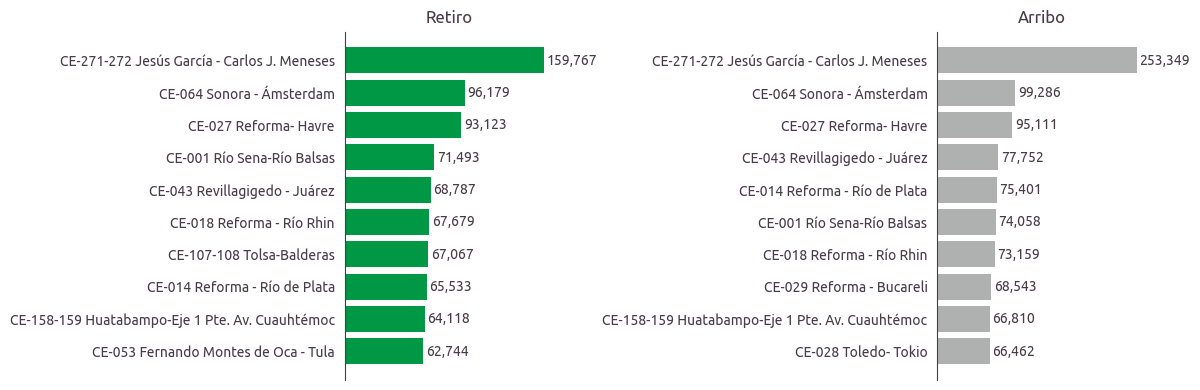

In [21]:
fig,axes  = plt.subplots(1,2,figsize=(12,4))
d = [d1,d2]
titles = ['Retiro','Arribo']
y = np.arange(d1.shape[0])
bipalete = palette[:2]

for i in np.arange(0,2):
    ax = axes[i]
    ax.barh(y,d[i]['count'],color=bipalete[i])
    ax.spines[['top','right','bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks(y)
    ax.set_yticklabels(d[i].name)
    ax.tick_params(left=False,labelsize=10)
    ax.set_title(titles[i])

    for ii,r in d[i].reset_index().iterrows():
        ax.annotate(f"{r['count']:,.0f}",xy=(r['count'],ii),xytext=(2,0),textcoords="offset points",ha="left",va='center')
plt.tight_layout();

In [22]:
d1 = df['Ciclo_Estacion_Retiro'].value_counts()
d2 = df['Ciclo_Estacion_Arribo'].value_counts()
d = d1.to_frame("Retiro").join(d2.to_frame("Arribo")).fillna(0)
d['difference'] = d.Retiro - d.Arribo
d['difference_abs'] = d.difference.abs()

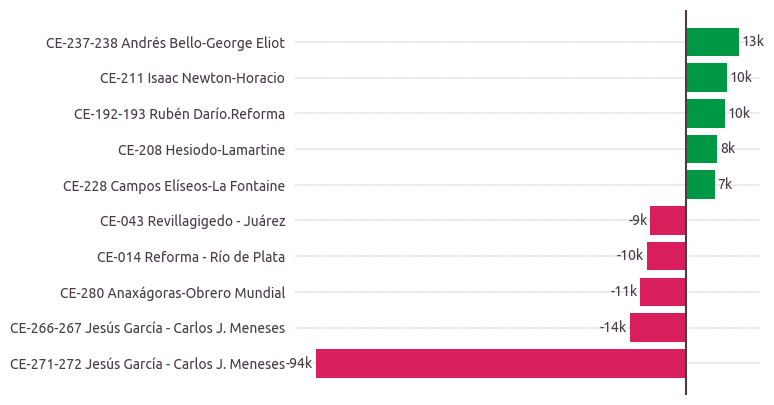

In [23]:
d_plot = pd.concat([d.sort_values("difference").head(),d.sort_values("difference").tail()],axis=0)

fig,ax= plt.subplots(figsize=(6,5))
x = np.arange(d_plot.shape[0])
ax.barh(x,d_plot.difference,color=[palette[0] if x>0 else palette[-1] for x in d_plot.difference],zorder=2)
ax.set_yticks(x)
ax.set_yticklabels(d_plot.index.map(stations.name))
ax.spines[['top','right','left','bottom']].set_visible(False)
ax.set_xticks([])
ax.tick_params(left=False)
ax.grid(True,axis="y",color=text_color,ls="--",lw=0.2,zorder=1)
ax.axvline(0,color=text_color,zorder=2)

c = 0
for i,r in d_plot.iterrows():
    ax.annotate(f"{r.difference/1e3:,.0f}k",xy=(r.difference,c),va='center',ha=('left' if r.difference>0 else 'right'),
               xytext=(2*(1 if r.difference>0 else -1),0), textcoords="offset points");
    c+=1;

## Longest trips

In [24]:
df['Retiro_lat'] = df['Ciclo_Estacion_Retiro'].map(stations.lat)
df['Retiro_lon'] = df['Ciclo_Estacion_Retiro'].map(stations.lon)
df['Arribo_lat'] = df['Ciclo_Estacion_Arribo'].map(stations.lat)
df['Arribo_lon'] = df['Ciclo_Estacion_Arribo'].map(stations.lon)
df.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,date_start,date_end,duration,file,year,Retiro_lat,Retiro_lon,Arribo_lat,Arribo_lon
21827075,M,44,3297082,150,2022-12-31,23:58:00.7540,040,2023-01-01,00:06:24.4320,2022-12-31 23:58:00.754,2023-01-01 00:06:24.432,503,data/2023-01.csv,2023,19.409894,-99.164288,19.422351,-99.164174
21827076,F,26,8922254,214,2022-12-31,23:36:34.3840,025,2023-01-01,00:07:08.8230,2022-12-31 23:36:34.384,2023-01-01 00:07:08.823,1834,data/2023-01.csv,2023,19.434353,-99.203220,19.427338,-99.166720
21827077,M,34,2320075,214,2022-12-31,23:36:33.7190,025,2023-01-01,00:07:12.5490,2022-12-31 23:36:33.719,2023-01-01 00:07:12.549,1838,data/2023-01.csv,2023,19.434353,-99.203220,19.427338,-99.166720
21827078,M,58,2096493,137,2022-12-31,23:57:19.0670,036,2023-01-01,00:07:48.4020,2022-12-31 23:57:19.067,2023-01-01 00:07:48.402,629,data/2023-01.csv,2023,19.418774,-99.157081,19.419660,-99.175880
21827079,M,23,6294433,260,2022-12-31,23:57:42.0100,043,2023-01-01,00:09:33.0770,2022-12-31 23:57:42.010,2023-01-01 00:09:33.077,711,data/2023-01.csv,2023,19.435311,-99.147786,19.435136,-99.146076


In [25]:
R = 6371

In [26]:
df['lat_d'] = (df.Retiro_lat - df.Arribo_lat)*np.pi/180
df['lon_d'] = (df.Retiro_lon - df.Arribo_lon)*np.pi/180
df['a'] = (np.sin(df.lat_d/2)**2)+\
    (np.cos(df.Arribo_lat*np.pi/180)*np.cos(df.Retiro_lat*np.pi/180)*(np.sin(df.lon_d/2)**2))
df['c'] = 2*np.arctan2(np.sqrt(df.a),np.sqrt(1-df.a))
df['distance'] = df.c*R

In [27]:
df.sort_values("distance",ascending=False).head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,date_start,...,year,Retiro_lat,Retiro_lon,Arribo_lat,Arribo_lon,lat_d,lon_d,a,c,distance
33233463,M,21,2497469,518,2023-12-11,00:17:58,651,2023-12-11,01:21:12,2023-12-11 00:17:58,...,2023,19.468315,-99.177386,19.351578,-99.150941,0.002037,-0.000462,1.085171e-06,0.002083,13.273540
32997600,M,34,4931192,521,2023-12-05,17:25:14,694,2023-12-05,18:43:20,2023-12-05 17:25:14,...,2023,19.466423,-99.173061,19.353243,-99.163753,0.001975,-0.000162,9.813843e-07,0.001981,12.622844
32937087,M,42,3775095,536,2023-12-04,14:49:29,708,2023-12-04,18:06:27,2023-12-04 14:49:29,...,2023,19.458881,-99.159215,19.346420,-99.145669,0.001963,-0.000236,9.755993e-07,0.001975,12.585585
28484665,M,44,8178691,537,2023-08-24,09:28:12,704,2023-08-24,10:34:19,2023-08-24 09:28:12,...,2023,19.457544,-99.159463,19.344976,-99.157824,0.001965,-0.000029,9.651698e-07,0.001965,12.518132
33234373,M,36,6135297,709,2023-12-11,06:06:35,461,2023-12-11,06:53:52,2023-12-11 06:06:35,...,2023,19.344237,-99.150065,19.440106,-99.210031,-0.001673,0.001047,9.435803e-07,0.001943,12.377334


In [28]:
stations.loc['518']

station_id                                                         594
external_id                       13b9e9ee-54f6-4243-909f-57b024b870d1
name                                     CE-518 Heliópolis - Norte 79A
lat                                                          19.468315
lon                                                         -99.177386
rental_methods                                       [CREDITCARD, KEY]
capacity                                                            27
electric_bike_surcharge_waiver                                   False
is_charging                                                      False
eightd_has_key_dispenser                                         False
has_kiosk                                                         True
Name: 518, dtype: object

In [29]:
stations.loc['651']

station_id                                                              526
external_id                            ba46d4ff-d914-42f3-9198-1c7dbc78b5ad
name                              CE-651 Héroes del 47 - División del Norte
lat                                                               19.351578
lon                                                              -99.150941
rental_methods                                            [CREDITCARD, KEY]
capacity                                                                 31
electric_bike_surcharge_waiver                                        False
is_charging                                                           False
eightd_has_key_dispenser                                              False
has_kiosk                                                              True
Name: 651, dtype: object

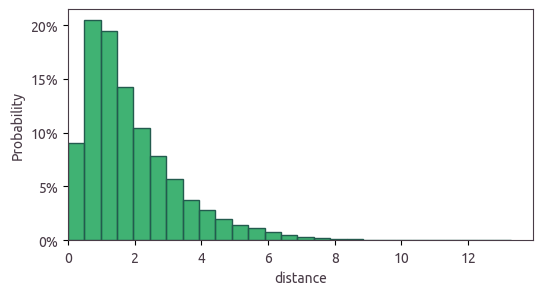

In [30]:
fig,ax = plt.subplots(figsize=(6,3))
sns.histplot(data=df,x='distance',ax=ax,binwidth=1/2,color=palette[0],ec=palette[2],stat='probability')
ax.set_xlim(0,ax.get_xlim()[1])
ax.yaxis.set_major_formatter(lambda x,p: f"{x:,.0%}");

In [ ]:
d = df.sort_values("distance",ascending=False).iloc[:10].iloc[::-1]

In [ ]:
fig,ax  = plt.subplots(figsize=(12,4))

y = np.arange(d.shape[0])
ax.barh(y,d.distance,color=palette[0])
ax.spines[['top','right','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks(y)
# ax.set_yticklabels(d.name)
ax.tick_params(left=False,labelsize=10)

for ii,r in d.iterrows():
    ax.annotate(f"{r.distance:,.0f}",xy=(r.distance,ii),xytext=(2,0),textcoords="offset points",ha="left",va='center')
plt.tight_layout();